In [10]:
import numpy
import numba
from numba import jit
from math import pi
from matplotlib import pyplot
%matplotlib inline

nx = 41
ny = 41

l = 1.
h = 1.

dx = l/(nx-1)
dy = h/(ny-1)

p = numpy.zeros((ny,nx))
w = numpy.zeros((ny,nx))

u=1.

l1_target = 10e-6

In [11]:
@jit
def L1norm(new, old):
    norm = numpy.sum(numpy.abs(new-old))
    
    return norm

In [12]:
@jit
def poisson_2d_1step(p, b, dx, dy):
    '''Performs Jacobi relaxation
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    b : 2D array of floats
        Source term
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l2_target: float
        Target difference between two consecutive iterates
    
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''
    pd = p.copy()

   
    p[1:-1,1:-1] = 1/(2*(dx**2 + dy**2)) * ((pd[1:-1,2:]+pd[1:-1,:-2])*dy**2 + (pd[2:,1:-1] + pd[:-2,1:-1])*dx**2 - b[1:-1,1:-1]*dx**2*dy**2)
    
    #enforcing BC elsewhere
    
    
    return p      

In [13]:
@jit
def enforceBCphi(p,dy,u):
#dirichlet condition
    #top
    p[:,-1]=0.
    #bottom
    p[:,0]=0.
    #left
    p[0,:]=0.
    #right
    p[-1,:]=0.
    
    return p

def enforceBCw(w,p,dx,dy,u):
    #neumann + laplace
    #top
    w[:,-1]=-(8*p[:,-2]-p[:, -3])/2/dy/dy - 3*u/dy
    #bottom
    w[:,1]=-(8*p[:,2]-p[:,3])/2/dy/dy
    #left
    w[1,:]=-(8*p[2,:]-p[3,:])/2/dx/dx
    #right
    w[-1,:]=-(8*p[-2,:]-p[-3,:])/2/dx/dx
    return w


In [14]:
@jit
def stokesSolver(p, w, dx, dy, nx, ny, l1Target, u, nloop):
    l1phi=1
    l1w=1
    i=0
    while l1phi>l1Target or l1w>l1Target:
        pd=p.copy()
        p= poisson_2d_1step(p.copy(), -w.copy(), dx, dy)
        p = enforceBCphi(p.copy(),dy,u)
        l1phi= L1norm(p, pd)
        wd=w.copy()
        w = poisson_2d_1step(w.copy(), numpy.zeros((p.shape)), dx, dy)
        w = enforceBCw(w.copy(),p.copy(),dx,dy,u)
        l1w=L1norm(w, wd)
        i+=1
    print(l1w, l1phi)
    print("nb loop")
    print(i) 
    return p, w

In [15]:
@jit
def plot2D(p, nx, ny, lx, ly):
    x=numpy.linspace(0, lx, nx)
    y=numpy.linspace(0, ly, ny)
    pyplot.figure(fisize=(8,5))
    pyplot.contourf(x,y,p,20,cmap=cm.viridis)
    pyplot.xlabel('$x$')
    pyplot.ylabel('$y$')
    pyplot.colorbar

In [16]:
p, w = stokesSolver(p.copy(), w.copy(), dx, dy, nx, ny ,l1_target, u, 4000)

9.95910381379765e-06 1.0984727792702077e-07
nb loop
3336


<function matplotlib.pyplot.colorbar>

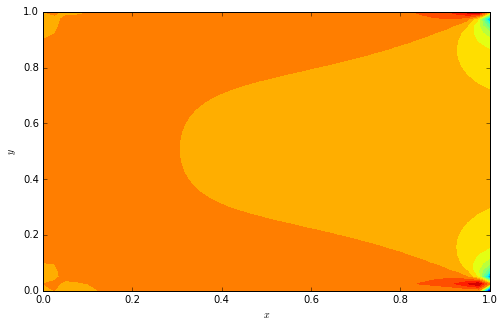

In [17]:
x=numpy.linspace(0, l, nx)
y=numpy.linspace(0, h, ny)
pyplot.figure(figsize=(8,5))
pyplot.contourf(x,y,w,20)
#pyplot.contourf(x, y, p, 20)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar

<function matplotlib.pyplot.colorbar>

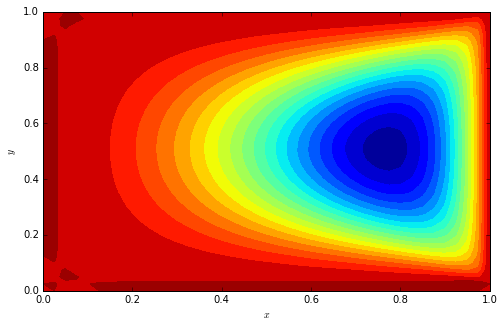

In [18]:
x=numpy.linspace(0, l, nx)
y=numpy.linspace(0, h, ny)
pyplot.figure(figsize=(8,5))
#pyplot.contourf(x,y,w,20)
pyplot.contourf(x, y, p, 20)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar

In [21]:
p[:,-2]

array([ 0.        ,  0.00429385, -0.00661488, -0.01354352, -0.01710854,
       -0.01901072, -0.02014206, -0.02088985, -0.02142289, -0.0218216 ,
       -0.02212906, -0.02237081, -0.02256319, -0.02271718, -0.02284043,
       -0.02293838, -0.02301494, -0.02307294, -0.0231144 , -0.02314068,
       -0.02315263, -0.02315062, -0.02313458, -0.02310402, -0.02305797,
       -0.02299488, -0.02291255, -0.0228079 , -0.02267668, -0.02251298,
       -0.02230852, -0.02205141, -0.02172395, -0.0212986 , -0.0207295 ,
       -0.01993323, -0.01874262, -0.01679996, -0.013364  , -0.0073263 ,  0.        ])

In [22]:
p[:,1]

array([  0.00000000e+00,   2.77327925e-07,  -9.56898904e-07,
        -1.57163430e-06,  -4.40214856e-07,   2.69076824e-06,
         7.68332095e-06,   1.42509389e-05,   2.20564313e-05,
         3.07513620e-05,   3.99940083e-05,   4.94589507e-05,
         5.88428857e-05,   6.78684117e-05,   7.62865555e-05,
         8.38784395e-05,   9.04563302e-05,   9.58642419e-05,
         9.99782305e-05,   1.02706489e-04,   1.03989335e-04,
         1.03799159e-04,   1.02140386e-04,   9.90494569e-05,
         9.45948446e-05,   8.88770661e-05,   8.20286354e-05,
         7.42138866e-05,   6.56285630e-05,   5.64990531e-05,
         4.70811168e-05,   3.76578985e-05,   2.85369162e-05,
         2.00454863e-05,   1.25234790e-05,   6.31081773e-06,
         1.72310150e-06,  -1.00178424e-06,  -1.82479992e-06,
        -1.14388357e-06,   0.00000000e+00])

In [23]:
print(p.max(), p.min(), w.max(), w.min())

0.0042938486315 -0.0980771126646 36.1971507821 -120.0


20.75609756097561